****We will try to find out similarity between paintings and also how machine learning algorithms do it****

In [1]:
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Importing our dataset

In [2]:
df = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
df = df.drop(columns=['bio', 'wikipedia'])

Here we will try to create the histogram of all of the paintings of an artist, so a type of average histogram, We are doing this because we want to see if we can find similarity based on this feature, after this we will move forward to machine learning.

In [3]:
artists_hist_dict = {}
for ii in glob.glob('../input/best-artworks-of-all-time/images/images/*'):
    blue_hist = []
    red_hist = []
    green_hist = []
    for j in glob.glob(ii + '/*'):
        img = cv2.imread(j)
        for i, col in enumerate(['b', 'g', 'r']):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            if col=='b':
                blue_hist.append(hist)
            elif col=='g':
                green_hist.append(hist)
            elif col=='r':
                red_hist.append(hist)

    blue_hist = sum(blue_hist)/len(blue_hist)
    green_hist = sum(green_hist)/len(green_hist)
    red_hist = sum(red_hist)/len(red_hist)
    artists_hist_dict[j.split('/')[-2]] = [blue_hist, green_hist, red_hist]

In [4]:
equivalent_artists = []
for i in artists_hist_dict:
    score_max = 0
    for j in artists_hist_dict:
        score = 0
        if i!=j:
            for k,l in zip(artists_hist_dict[j], artists_hist_dict[i]):     
                score = score + cv2.compareHist(k, l, cv2.HISTCMP_CORREL)
                score = score/3.0
            if score > score_max:
                score_max = score
                similar_artist = j
    equivalent_artists.append((i,similar_artist, score_max))

In [5]:
def plot(artist_1,  artist_2, title_of_plot):
    blue_hist1, green_hist1, red_hist1 = artists_hist_dict[artist_1]
    blue_hist2, green_hist2, red_hist2 = artists_hist_dict[artist_2]
    fig, axs = plt.subplots(2,figsize=(5,5))
    fig.tight_layout()
    #fig.suptitle('score :' + title_of_plot )
    axs[0].title.set_text(artist_1)
    axs[0].plot(blue_hist1, color = 'b')
    axs[0].plot(green_hist1, color = 'g')
    axs[0].plot(red_hist1, color = 'r')
    axs[1].title.set_text(artist_2)
    axs[1].plot(blue_hist2, color = 'b')
    axs[1].plot(green_hist2, color = 'g')
    axs[1].plot(red_hist2, color = 'r')

Let's find closest artists based on histogram

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


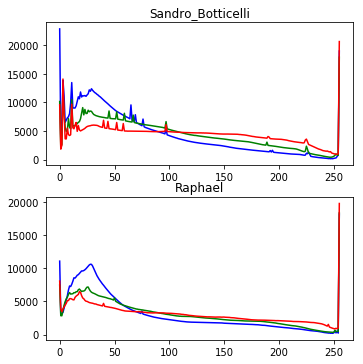

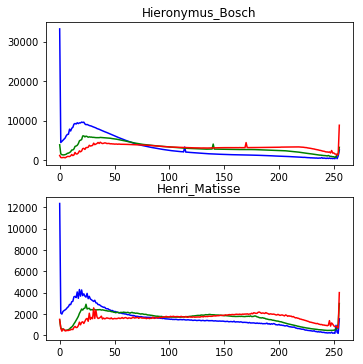

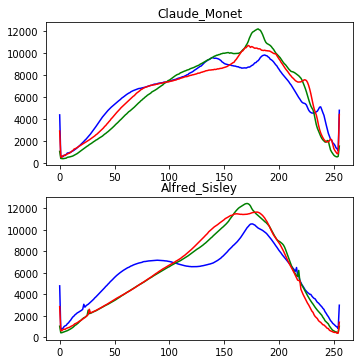

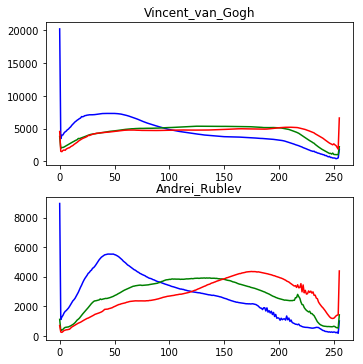

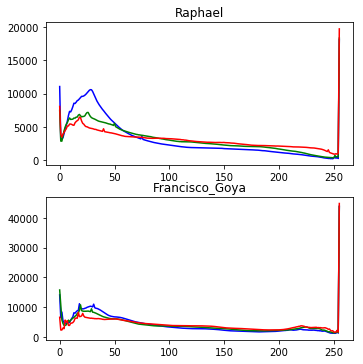

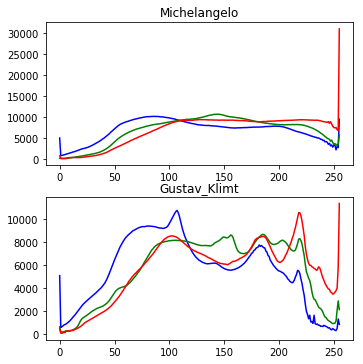

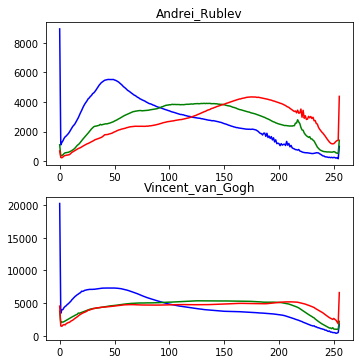

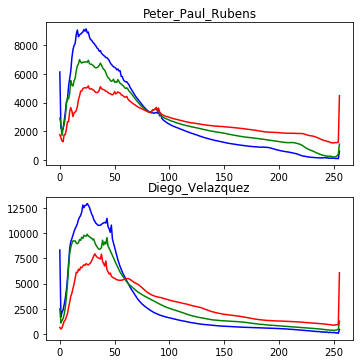

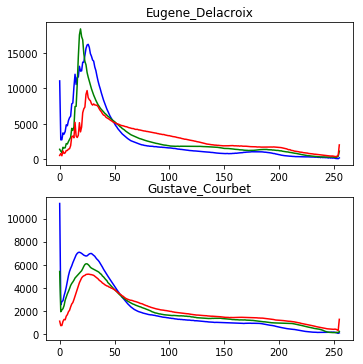

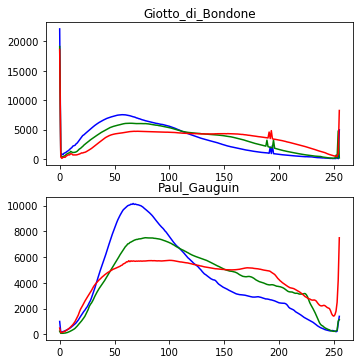

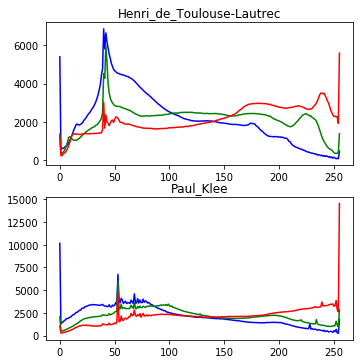

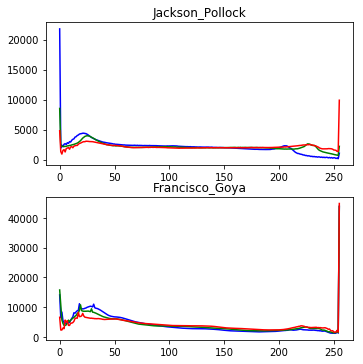

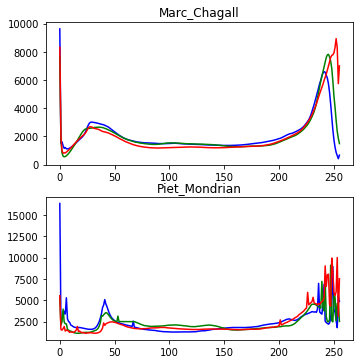

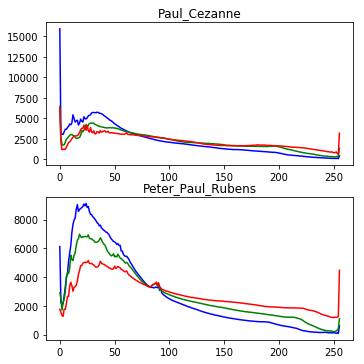

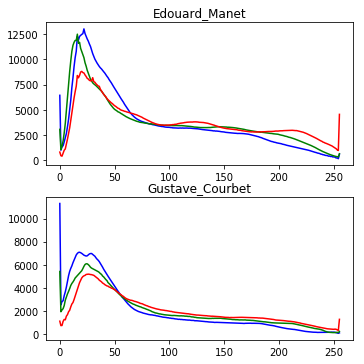

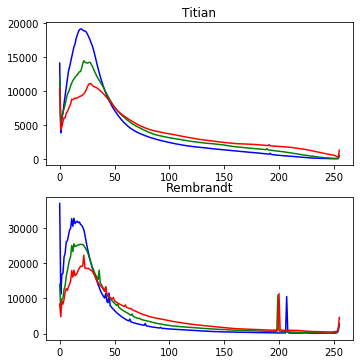

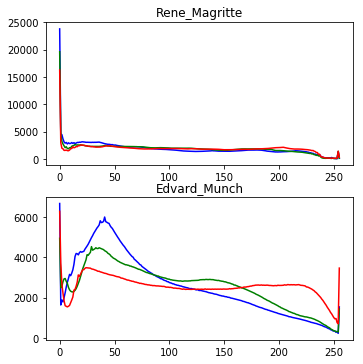

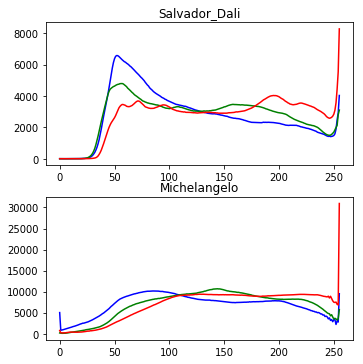

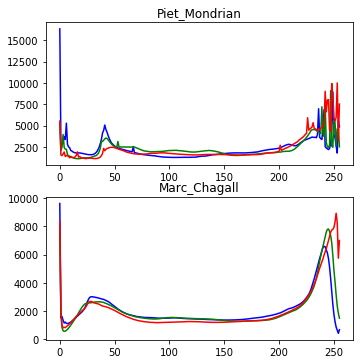

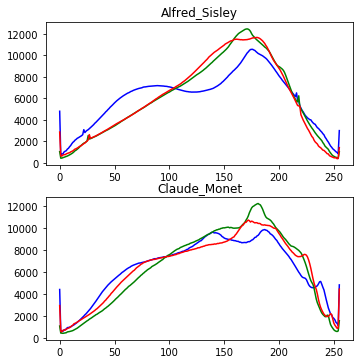

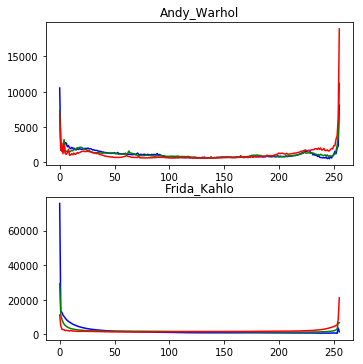

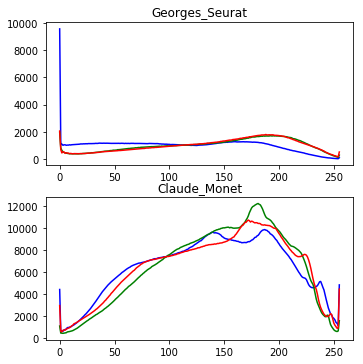

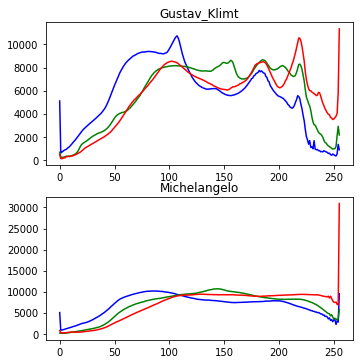

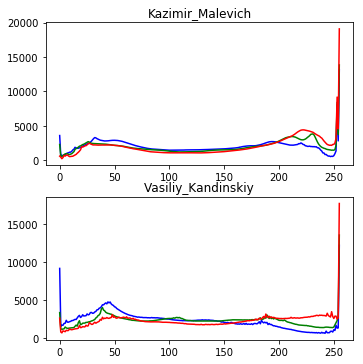

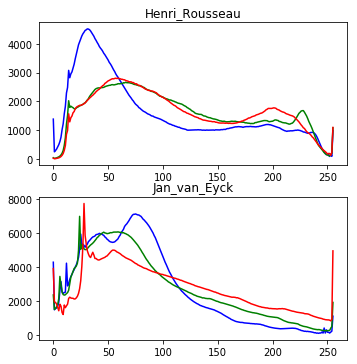

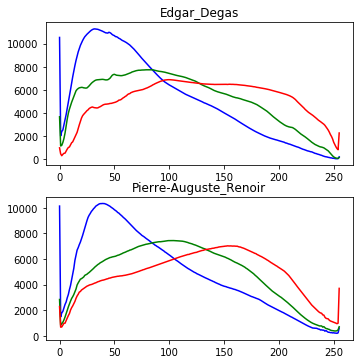

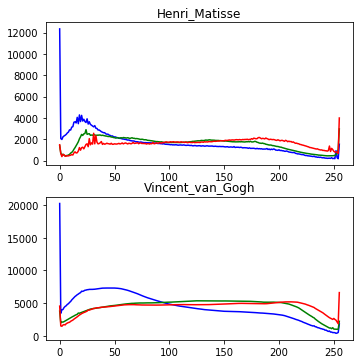

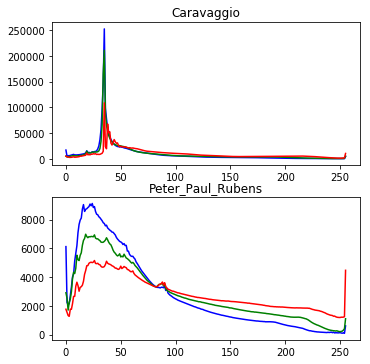

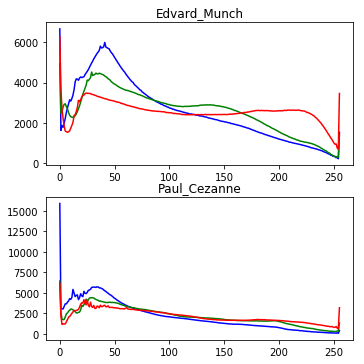

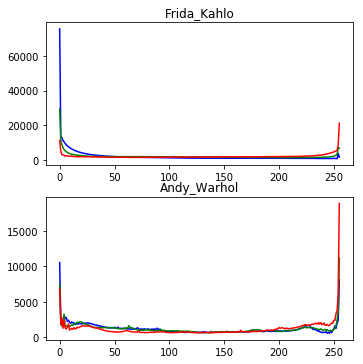

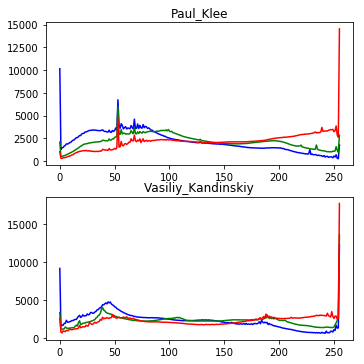

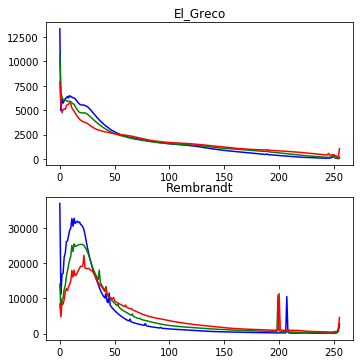

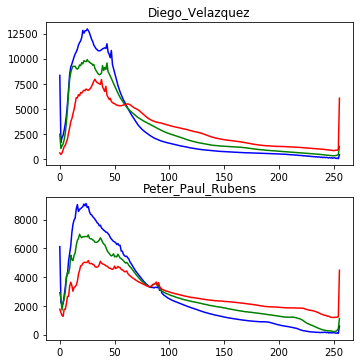

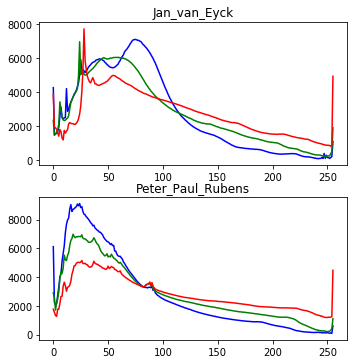

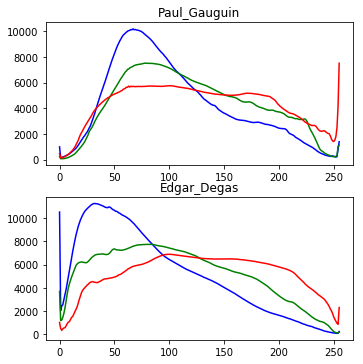

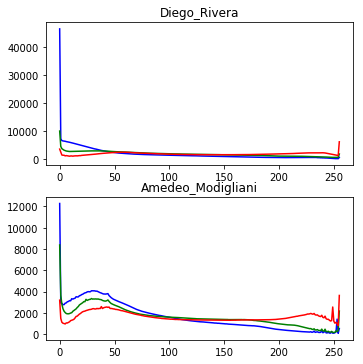

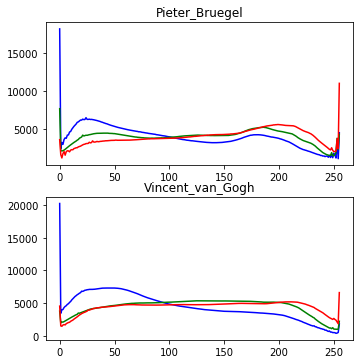

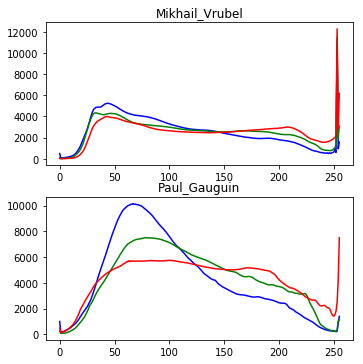

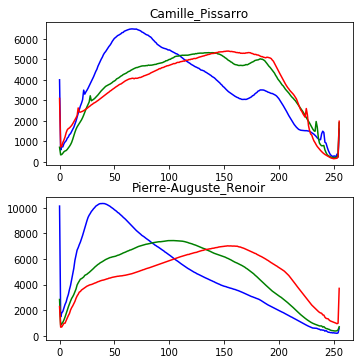

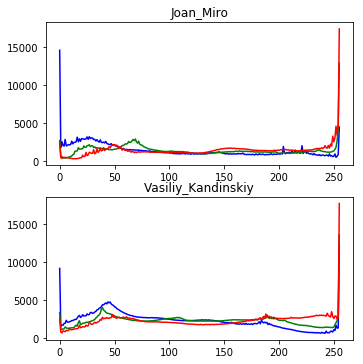

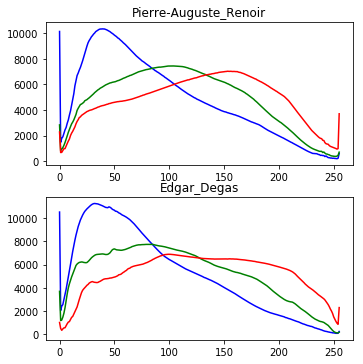

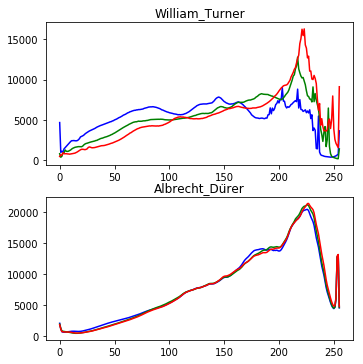

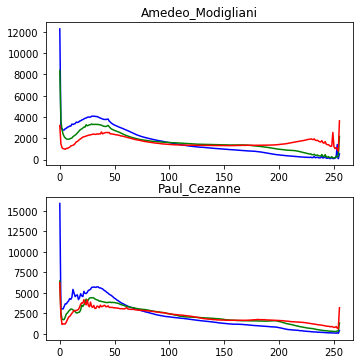

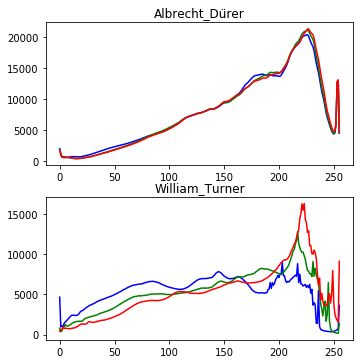

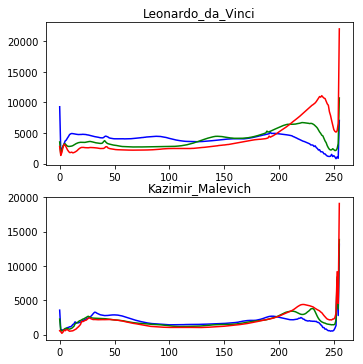

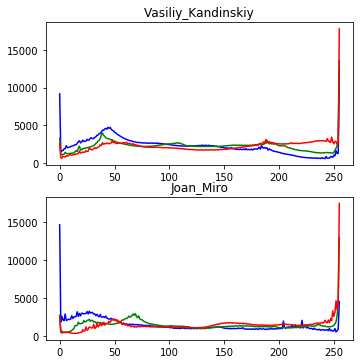

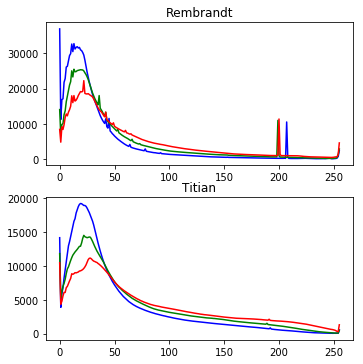

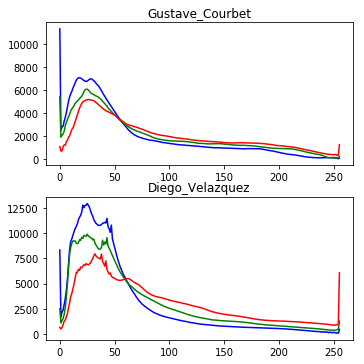

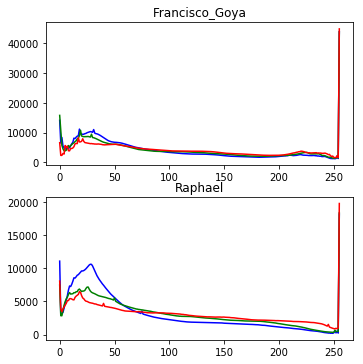

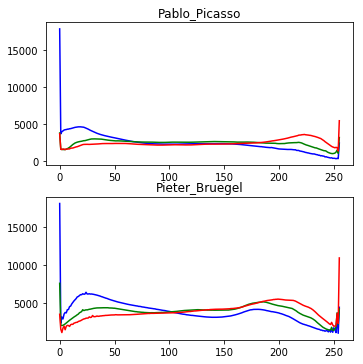

In [6]:
for i in equivalent_artists:
    plot(i[0], i[1], str(i[2]))

****From here we will try to make an autoencoder**** 

In [7]:
all_artwork = []
all_labels = []
for ii in glob.glob('../input/best-artworks-of-all-time/images/images/*'):
    for j in glob.glob(ii + '/*'):
        all_artwork.append(cv2.resize(cv2.imread(j), (128,128)))
        all_labels.append(ii.split('/')[-1])

In [8]:
all_artwork = np.asarray(all_artwork)

In [9]:
import gc
gc.collect()

229552

The aim of the encoder is so that we can get a compressed representation,  
later we will apply T-SNE to see if the compressions are distributed like the training data or not.

In [10]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import keras

Using TensorFlow backend.


In [11]:
inputs = Input(shape=(128,128,3))
##--encoder--##
conv = Conv2D(8, kernel_size=3, activation='relu')(inputs)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(8, kernel_size=3, activation='relu')(conv)
conv = Conv2D(8, kernel_size=3, activation='relu')(conv)
conv = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(16, kernel_size=3, activation='relu')(conv)
###
deconv = Conv2DTranspose(16, kernel_size=3, activation='relu')(conv)
deconv = UpSampling2D(size=(2, 2),interpolation='nearest')(deconv)
deconv = Conv2DTranspose(8, kernel_size=3, activation='relu')(deconv)
deconv = Conv2DTranspose(8, kernel_size=3, activation='relu')(deconv)
deconv = UpSampling2D(size=(2, 2),interpolation='nearest')(deconv)
deconv = Conv2DTranspose(8, kernel_size=3, activation='relu')(deconv)
##--get--back--image--##
img = Conv2DTranspose(3, kernel_size=3, activation='relu')(deconv)

model = Model(inputs=inputs, outputs=img)

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 8)         584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 16)        1168

In [13]:
optimizer = Adam(lr = 0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
gc.collect()

0

In [15]:
history_model = model.fit(all_artwork/255.0,  all_artwork/255.0, shuffle= True, epochs = 30,  batch_size=8,verbose=1)
print(history_model)

Epoch 1/30
8446/8446 [==============================] - 13s 2ms/step - loss: 0.9124 - accuracy: 0.0075
Epoch 2/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5921 - accuracy: 0.0098
Epoch 3/30
8446/8446 [==============================] - 11s 1ms/step - loss: 0.5797 - accuracy: 0.0100
Epoch 4/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5735 - accuracy: 0.0102
Epoch 5/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5704 - accuracy: 0.0103
Epoch 6/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5635 - accuracy: 0.0104
Epoch 7/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5588 - accuracy: 0.0105
Epoch 8/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5565 - accuracy: 0.0106
Epoch 9/30
8446/8446 [==============================] - 10s 1ms/step - loss: 0.5537 - accuracy: 0.0107
Epoch 10/30
8446/8446 [==============================] - 10s 1ms/step - l

In [16]:
for ind, layer in enumerate(model.layers):
    print(ind," ",layer.name)

0   input_1
1   conv2d_1
2   max_pooling2d_1
3   conv2d_2
4   conv2d_3
5   max_pooling2d_2
6   conv2d_4
7   conv2d_transpose_1
8   up_sampling2d_1
9   conv2d_transpose_2
10   conv2d_transpose_3
11   up_sampling2d_2
12   conv2d_transpose_4
13   conv2d_transpose_5


The model we have created is very small, and with very few parameters, our aim is to just create a model which compresses images, we dont aim for a great reconstructor, we just want to extract features from the model.

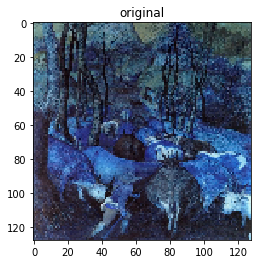

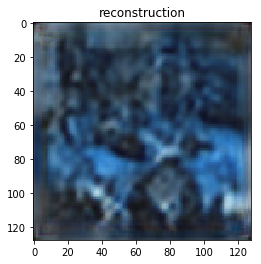

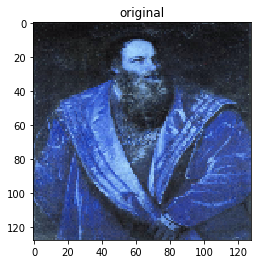

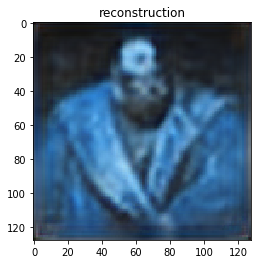

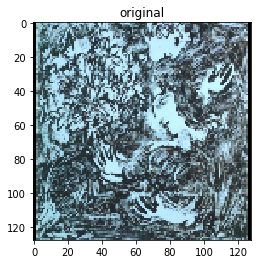

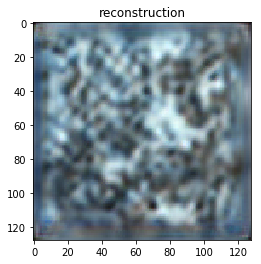

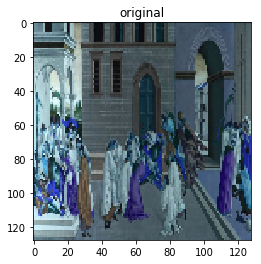

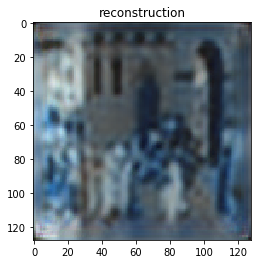

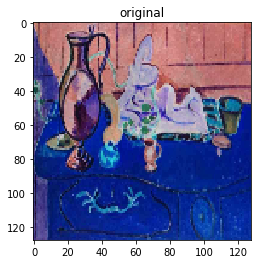

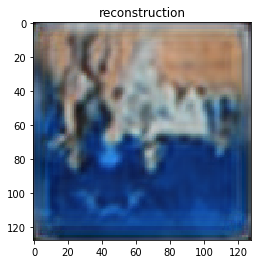

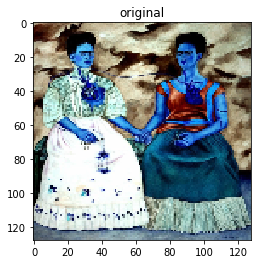

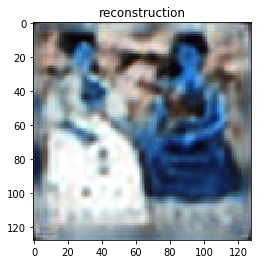

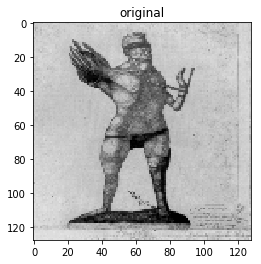

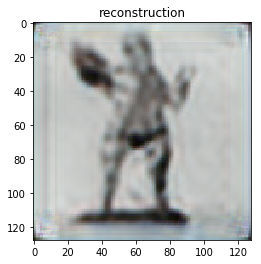

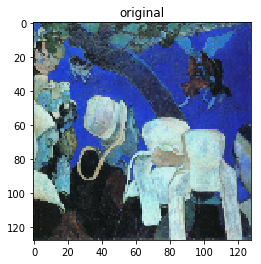

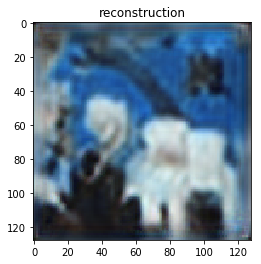

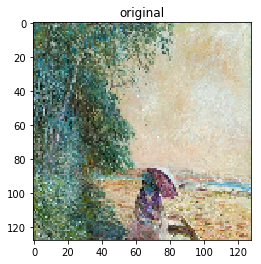

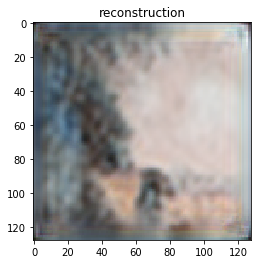

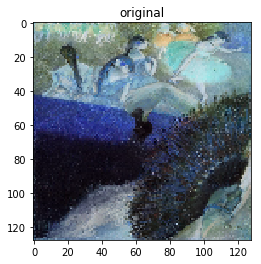

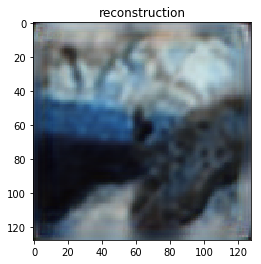

In [17]:
import random
for i in [random.randint(0, len(all_artwork)) for i in range(10)]:
    original_art_works =all_artwork[i]
    plt.title('original')
    plt.imshow(original_art_works)
    plt.show()
    reconstructed_art_works = np.squeeze(model.predict(np.asarray([original_art_works/255.0])))
    plt.title('reconstruction')
    plt.imshow(reconstructed_art_works)
    plt.show()

Let;s get the compressed feature from the model

In [18]:
model_output = model.get_layer(model.layers[6].name).output
get_latent_vector = Model(inputs=model.input, outputs=model_output)

In [19]:
gc.collect()

43607

In [20]:
latent_vectors = []
latent_labels = []
all_artwork = []
for ii in glob.glob('../input/best-artworks-of-all-time/images/images/*'):
    for j in glob.glob(ii + '/*'):
        all_artwork.append(cv2.resize(cv2.imread(j), (128,128)))
        latent_vectors.append(np.squeeze(get_latent_vector.predict(np.asarray([cv2.resize(cv2.imread(j), (128,128))/255.0]))))
        latent_labels.append(ii.split('/')[-1])

In [21]:
import random

c = list(zip(all_artwork,  latent_vectors, latent_labels))

random.shuffle(c)

all_artwork, latent_vectors, latent_labels = zip(*c)

In [22]:
gc.collect()

42

In [23]:
lv = []
for i in range(len(latent_vectors)):
    lv.append(np.reshape(latent_vectors[i],  (27*27*16)))

In [24]:
latent_labels = np.asarray(latent_labels)

(2000, 2)


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


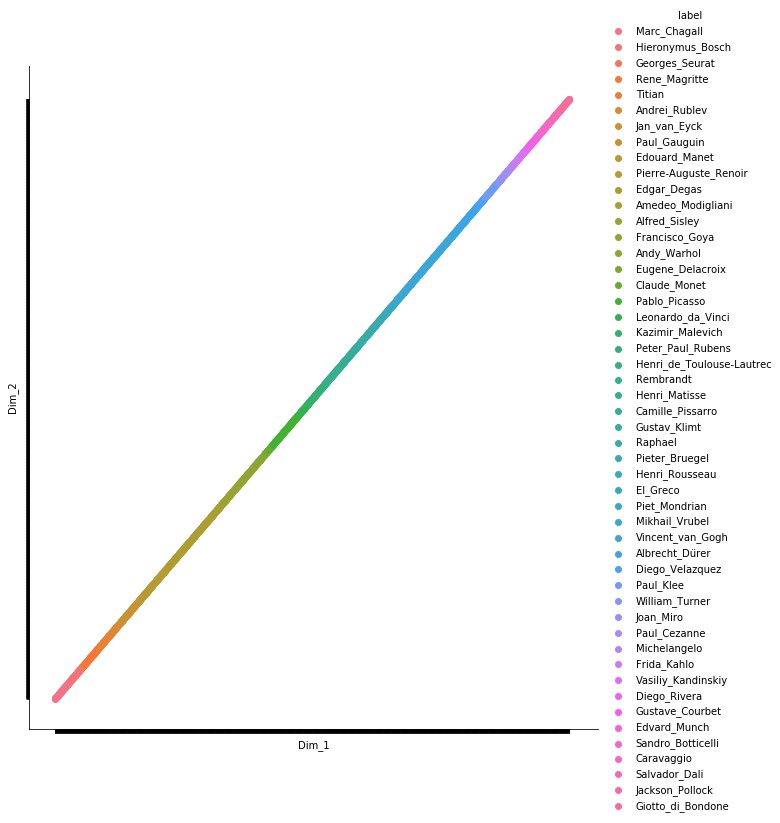

In [25]:
import pandas as pd
import seaborn as sn
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0,  perplexity=1000, learning_rate=100.0)
data = tsne_model.fit_transform(np.asarray(lv[0:2000]))
print(data.shape)
tsne_data = np.vstack((data.T, latent_labels[0:2000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
g = sn.FacetGrid(tsne_df, hue="label",  size=10).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
g.set(xticklabels=[], yticklabels=[])
plt.show()

In [26]:
lv1 = []
for i in range(len(all_artwork)):
    lv1.append(np.reshape(all_artwork[i],  (128*128*3)))

(2000, 2)


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


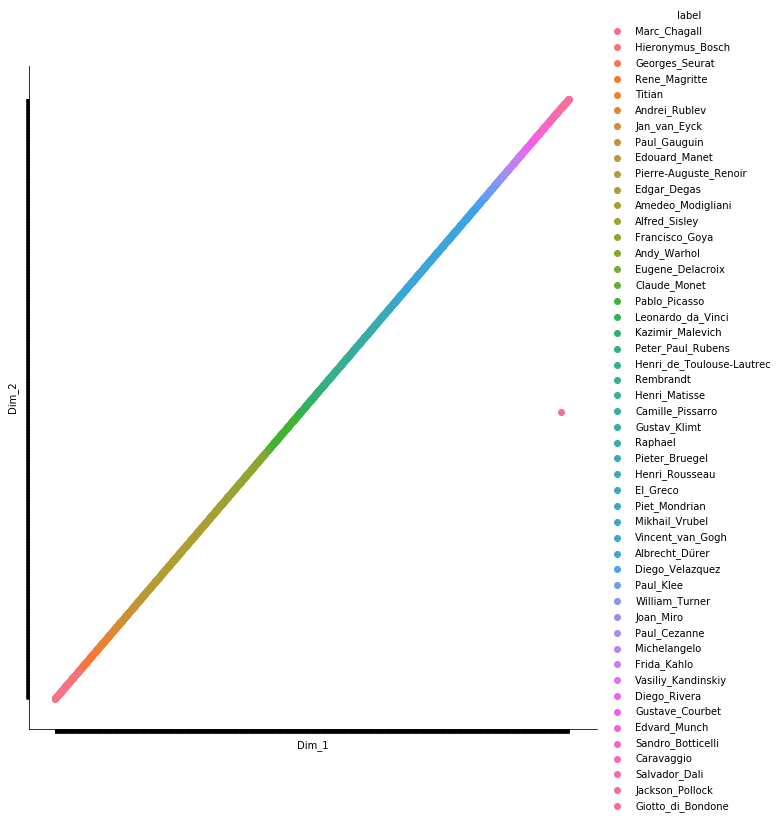

In [27]:
import pandas as pd
import seaborn as sn
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0,  perplexity=2000, learning_rate=200.0)
data = tsne_model.fit_transform(np.asarray(lv1[0:2000])/255.0)
print(data.shape)
tsne_data = np.vstack((data.T, latent_labels[0:2000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
g = sn.FacetGrid(tsne_df, hue="label",  size=10).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
g.set(xticklabels=[], yticklabels=[])
plt.show()

Let's see what features did our compressed feature even extracts

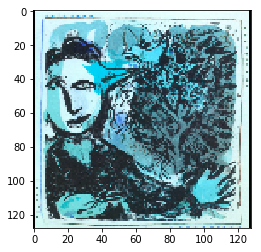

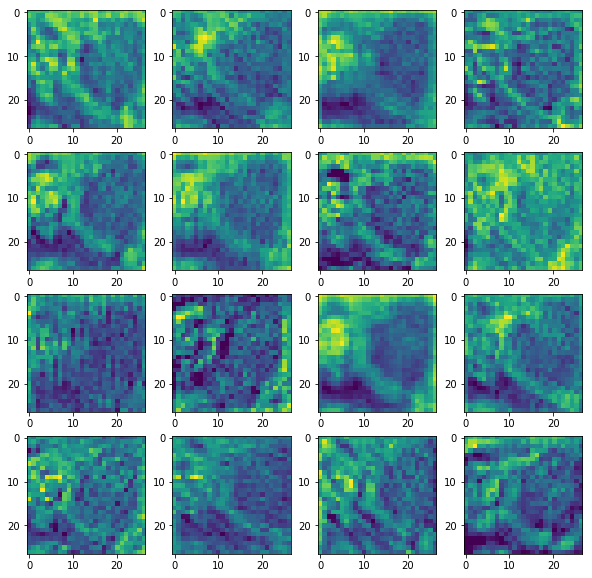

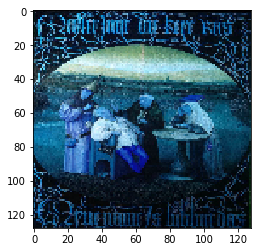

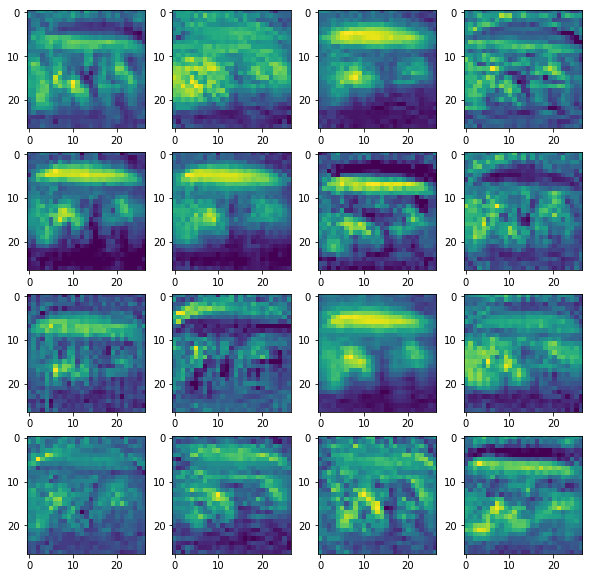

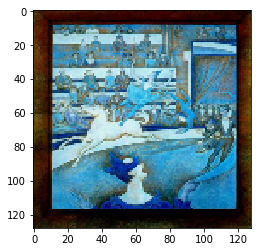

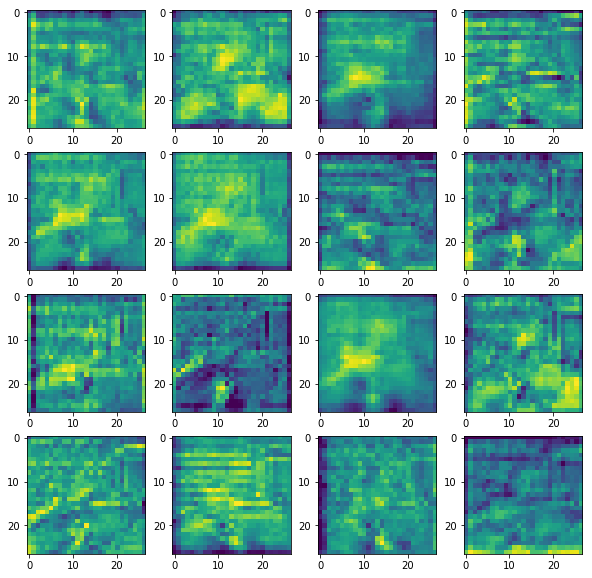

In [28]:
import matplotlib.pyplot as plt

for kk in range(3):
    plt.imshow(all_artwork[kk])
    plt.show()
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize = (10,10))

    i = 0
    for row in ax:
        for col in row:
            col.imshow(latent_vectors[kk][:,:,i])
            i = i+1

    plt.show()